In [1]:
import sys
import numpy as np
import math
import ceo
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

In [2]:
# Telescope parameters
D = 25.5

# WFS parameters
nLenslet = 25  # number of sub-apertures across the pupil
n = 16         # number of pixels per subaperture
detectorRes = 2*n*nLenslet/2

nPx = n*nLenslet+1
print "pupil sampling:      %d pixel"%nPx
print "detector resolution: %d pixel"%detectorRes

# number of Guide Stars and position
N_GS = 3    # NUMBER of GSs
alpha =6*60.  # radius of circle where GSs are located [in arcsec]
zenith_angle  = np.ones(N_GS)*alpha*math.pi/180/3600 # in radians
azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees

# Initialize GS, WFS, SPS, and GMT objects
gs = ceo.Source("I",zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=2,N_GS=N_GS)
gmt = ceo.GMT_MX(D,nPx)
ps = ceo.SegmentPistonSensor(gmt, gs)

# Initialize on-axis GS for performance evaluation
ongs = ceo.Source("I",zenith=0.,azimuth=0., rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

pupil sampling:      401 pixel
detector resolution: 400 pixel


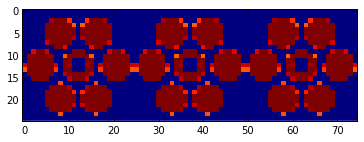

In [3]:
# Calibrate WFS slope null vector
gs.reset()
gmt.reset()   # Telescope perfectly phased
gmt.propagate(gs)
wfs.calibrate(gs,0.8)
plt.imshow(wfs.flux.host(shape=(nLenslet*3,nLenslet)).T,interpolation='none')

<matplotlib.colorbar.Colorbar instance at 0x2b127a599e60>

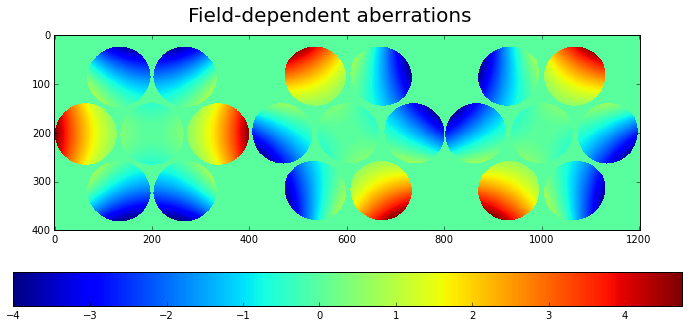

In [4]:
# Calibrate SPS reference vector (corresponding to field-dependent aberrations)
gs.reset()
gmt.reset()
gmt.propagate(gs)
ph_fda = gs.phase.host(units='micron').T
SPSmeas_ref = ps.piston(gs, segment='edge')

fig, ax = plt.subplots()
fig.set_size_inches(20,5)
fig.suptitle('Field-dependent aberrations', fontsize=20)
imm = ax.imshow(ph_fda, interpolation='None')
fig.colorbar(imm, orientation='horizontal', shrink=0.6)

In [5]:
# Calibrate M2 segment TT Interaction Matrix and Reconstructor
TTstroke = 25e-3 #arcsec
gmt.reset()
D_M2_TT = gmt.calibrate(wfs, gs, mirror="M2", mode="segment tip-tilt", stroke=TTstroke*math.pi/180/3600)
R_M2_TT = np.linalg.pinv(D_M2_TT)
R_M2_TT.shape

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------


(14, 1692)

___ M1 ___
Segment #:1 2 3 4 5 6 
------------


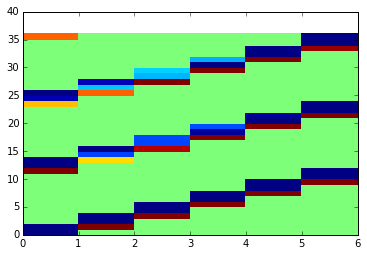

In [6]:
# Calibrate Idealized Segment Piston Sensor Interaction Matrix and Reconstructor
PSstroke = 200e-9 #m
gmt.reset()
D_M1_PS = gmt.calibrate(ps, gs, mirror="M1", mode="segment piston", stroke=PSstroke, segment='edge')
R_M1_PS = np.linalg.pinv(D_M1_PS)
R_M1_PS.shape
plt.pcolor(D_M1_PS)

### Close-loop correction with conventional calibrations
The correction comprises:

1) M2 segment tip-tilt (sensed with 3 SH WFS)

2) M1 segment piston (sensed with 3 SPS)

Note: If you introduce a segment tip-tilt on M1 it will be compensated by M2, and therefore a Field-Dependent Segment Piston (FDSP) will be created. This FDSP will be seen by the 3 SPS and will try to compensate for it, introducing additional errors! 

### Close loop correction with Brian's FDSP calibrations
The correction comprises:

1) M2 segment tip-tilt (sensed with 3 SH WFS)

2) FDSP (sensed with 3 SPS)

3) M1 segment piston (sensed with 3 SPS)



___ M1 ___
Segment #:1 2 3 4 5 6 
------------


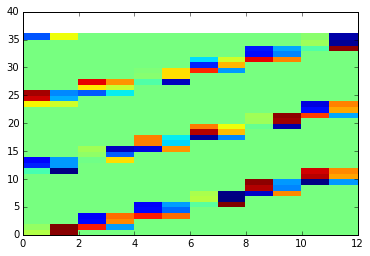

In [7]:
# Calibrate FDSP Interaction Matrix and Reconstructor
TTstroke = 50e-3 #arcsec
gmt.reset()
D_FDSP = gmt.calibrate(ps, gs, mirror="M1", mode="FDSP", stroke=TTstroke*math.pi/180/3600, segment='edge', 
                        agws=wfs, recmat=R_M2_TT)
R_FDSP = np.linalg.pinv(D_FDSP)
R_FDSP.shape
plt.pcolor(D_FDSP)

(18, 36)


<matplotlib.colorbar.Colorbar instance at 0x2b127af3e6c8>

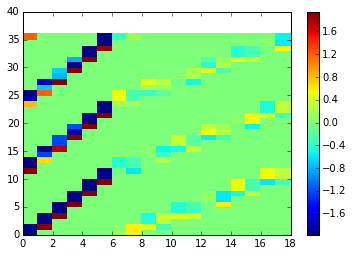

In [8]:
##### Combine Interaction Matrices of M1 segment piston AND FDSP.
D_PIST = np.concatenate((D_M1_PS, D_FDSP), axis=1)
R_PIST = np.linalg.pinv(D_PIST)
print R_PIST.shape
plt.pcolor(D_PIST)
plt.colorbar()

In [42]:
##### Reset before starting
gs.reset()
gmt.reset()

<matplotlib.colorbar.Colorbar instance at 0x2b127bc15e60>

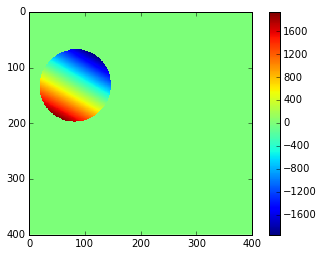

In [43]:
##### Apply a known Tilt to a particular segment on M1
M1RotVec = np.array([  #arcsec
            [0,0,0] ,
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,50e-3,0],
            [0,0,0],
            [0,0,0]]) * math.pi/180/3600   

##### Apply a know segment piston/translation to a particular segment on M1
M1TrVec = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]])

for idx in range(7): gmt.M1.update(origin=M1TrVec[idx,:], euler_angles=M1RotVec[idx,:], idx=idx+1)

##### Apply a known Tilt to a particular segment on M2
M2RotVec = np.array([  #arcsec
            [0,0,0] ,
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]]) * math.pi/180/3600   

##### Apply a know segment piston/translation to a particular segment on M2
M2TrVec = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]])

for idx in range(7): gmt.M2.update(origin=M2TrVec[idx,:], euler_angles=M2RotVec[idx,:], idx=idx+1)    

ongs.reset()
gmt.propagate(ongs)
plt.imshow(ongs.phase.host(units='nm'),interpolation='None')
plt.colorbar()

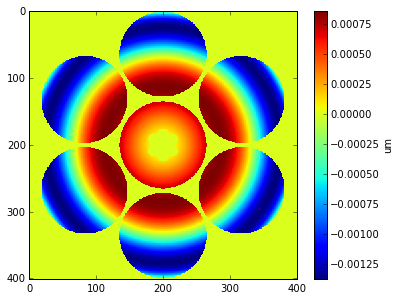

In [44]:
##### Close the loop !!!!!
f, ax = plt.subplots()
f.set_size_inches(6,8)
niter = 4
TTniter = 10
rmsval = np.zeros(niter*TTniter)
myTTest1 = np.zeros((7,2))
myPSest1 = np.zeros(6)
myFDSPest1 = np.zeros((6,2))  #6x M1 segment tip-tilt
for ii in range(niter):
    for jj in range(TTniter):
        ongs.reset()
        gmt.propagate(ongs)
        rmsval[ii*TTniter+jj] = ongs.wavefront.rms()
        #---- visualization
        if ii*TTniter+jj > 0: clb.remove()
        h = ax.imshow(ongs.phase.host(units='micron'),interpolation='None')
        clb = f.colorbar(h, ax=ax, shrink=0.6)
        clb.set_label('um')
        IPython.display.clear_output(wait=True)
        IPython.display.display(f)
        #---- segment TT correction
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
        slopevec = wfs.valid_slopes.host().ravel()
        myTTest1 += np.dot(R_M2_TT, slopevec).reshape((7,2))
        M2RotCor = np.zeros((7,3))
        M2RotCor[:,0:2] = myTTest1
        M2RotVec1 = M2RotVec - M2RotCor
        for idx in range(7): gmt.M2.update(origin=M2TrVec[idx,:], euler_angles=M2RotVec1[idx,:], idx=idx+1)
    
    ####### FDSP and segment piston correction
    gs.reset()
    gmt.propagate(gs)
    PISTmeas = ps.piston(gs, segment='edge') - SPSmeas_ref
    myPISTest1 = np.dot(R_PIST, PISTmeas.ravel())
    #--- segment piston
    myPSest1 += myPISTest1[0:6]
    M1TrCor = np.zeros((7,3))
    M1TrCor[0:6,2] = myPSest1
    M1TrVec1 = M1TrVec - M1TrCor
    #--- FDSP
    myFDSPest1 += myPISTest1[6:].reshape((6,2))
    M1RotCor = np.zeros((7,3))
    M1RotCor[0:6,0:2] = myFDSPest1
    M1RotVec1 = M1RotVec - M1RotCor    
    for idx in range(7): gmt.M1.update(origin=M1TrVec1[idx,:], euler_angles=M1RotVec1[idx,:], idx=idx+1)
    """
    ####### FDSP correction only
    gs.reset()
    gmt.propagate(gs)
    FDSPmeas = ps.piston(gs, segment='edge') - SPSmeas_ref
    myFDSPest1 += np.dot(R_FDSP, FDSPmeas.ravel()).reshape((6,2))
    M1RotCor = np.zeros((7,3))
    M1RotCor[0:6,0:2] = myFDSPest1
    M1RotVec1 = M1RotVec - M1RotCor
    for idx in range(7): gmt.M1.update(origin=M1TrVec[idx,:], euler_angles=M1RotVec1[idx,:], idx=idx+1)

    ####### segment Piston correction only
    gs.reset()
    gmt.propagate(gs)
    SPSmeas = ps.piston(gs, segment='edge') - SPSmeas_ref
    myPSest1 += np.dot(R_M1_PS, SPSmeas.ravel())
    M1TrCor = np.zeros((7,3))
    M1TrCor[0:6,2] = myPSest1
    M1TrVec1 = M1TrVec - M1TrCor
    for idx in range(7): gmt.M1.update(origin=M1TrVec1[idx,:], euler_angles=M1RotVec[idx,:], idx=idx+1)
    """
plt.close()

segment tip-tilt
[[ -8.13266792e-05   1.90967691e-04]
 [ -1.45096948e-04  -1.22440446e-04]
 [  2.08487751e-04   4.16294414e-04]
 [  3.58631175e-04   2.60848377e-04]
 [  1.69383178e-04   5.34758707e-05]
 [ -5.90457294e-05   1.92434857e-04]
 [ -1.28048715e-27   9.91387155e-21]]
segment piston
[ 0.  0.  0.  0.  0.  0.]
FDSP
[[  9.77057549e-06  -1.44299665e-06]
 [ -7.22758938e-06  -6.41809109e-05]
 [  4.41106987e-05   4.44245992e-06]
 [  2.73366916e-05   7.24888590e-06]
 [  2.42902501e-05   4.99999994e+01]
 [ -1.05256097e-05   1.90236312e-06]]


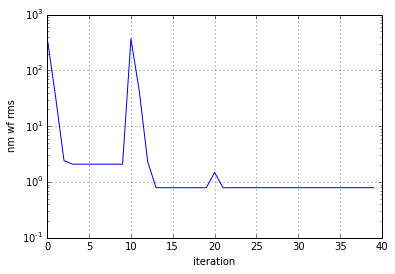

In [45]:
plt.semilogy(rmsval*1e9)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('nm wf rms')
print 'segment tip-tilt'
print myTTest1*180*3600/math.pi*1e3
print 'segment piston'
print myPSest1*1e9
print 'FDSP'
print myFDSPest1*180*3600/math.pi*1e3

In [54]:
rmsval*1e9

array([ 399.63688891,  110.08312839,  102.75623197,  102.77877749,
        102.78037621,  373.39182768,   34.28327133,    3.93553634,
          3.86427645,    3.86367249,    9.41300726,    0.97317421,
          0.96039121,    0.96056829,    0.96059305,    2.02663442,
          0.79689239,    0.80139673,    0.80131257,    0.8013657 ,
          0.79200052,    0.79237039,    0.79242607,    0.7924077 ,
          0.7924556 ])